# Emotional Analysis of tweets posted during Indian Election **2019**


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
!ls "/content/drive/My Drive/Final_Practicum/Emotional_Analysis"

Emotional_Analysis_for_Election.ipynb  new_text_emotion_predict_data.csv
Emotion_Detection.csv		       text_emotion_cleaned.csv
Emotion_model.h5		       text_emotion.csv
new_text_emotion_cleaned.csv	       train_data.csv


###Importing NLTK libraries


In [0]:
import nltk
from nltk.corpus import stopwords
nltk.download('wordnet')
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


###Importing libraries used for claening, splitting data, embeddings and models 

In [0]:
import pandas as pd
import numpy as np

import re
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import MultinomialNB


### Reading the Emotion corpus

In [0]:
data = pd.read_csv('/content/drive/My Drive/Final_Practicum/Emotional_Analysis/text_emotion.csv')
data['content']=data['content'].astype(str)
data = data.drop('author', axis=1)
data.head()

,tweet_id,sentiment,content
0,1956967341,empty,@tiffanylue i know i was listenin to bad habi...
1,1956967666,sadness,Layin n bed with a headache ughhhh...waitin o...
2,1956967696,sadness,Funeral ceremony...gloomy friday...
3,1956967789,enthusiasm,wants to hang out with friends SOON!
4,1956968416,neutral,@dannycastillo We want to trade with someone w...


In [0]:
data.shape

(40000, 3)

###Checking the counts of labels in entire dataset

In [0]:
tags_count_df = data.groupby(['sentiment']).count()
tags_count_df

,tweet_id,content
sentiment,,
anger,110,110
boredom,179,179
empty,827,827
enthusiasm,759,759
fun,1776,1776
happiness,5209,5209
hate,1323,1323
love,3842,3842
neutral,8638,8638


###Ploting the labels with their count

[Text(0, 0, 'empty'),
 Text(0, 0, 'sadness'),
 Text(0, 0, 'enthusiasm'),
 Text(0, 0, 'neutral'),
 Text(0, 0, 'worry'),
 Text(0, 0, 'surprise'),
 Text(0, 0, 'love'),
 Text(0, 0, 'fun'),
 Text(0, 0, 'hate'),
 Text(0, 0, 'happiness'),
 Text(0, 0, 'boredom'),
 Text(0, 0, 'relief'),
 Text(0, 0, 'anger')]

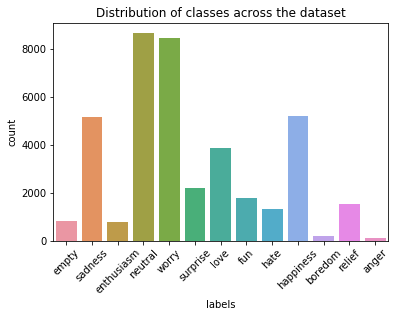

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
chart=sns.countplot(data.sentiment)
plt.xlabel('labels')
plt.title('Distribution of classes across the dataset')
chart.set_xticklabels( chart.get_xticklabels(),rotation=45)

### Remove special patterns of twitter

In [0]:
tidy_tweets=[]
def remove_pattern(text, pattern_regex):
    r = re.findall(pattern_regex, text)
    for i in r:
        text = re.sub(i, '', text)
    
    return text
data['tidy_tweets'] = np.vectorize(remove_pattern)(data['content'], "@[\w]* | *RT*")
print(data.head(10))

     tweet_id  ...                                        tidy_tweets
0  1956967341  ...  i know  i was listenin to bad habit earlier an...
1  1956967666  ...  Layin n bed with a headache  ughhhh...waitin o...
2  1956967696  ...                Funeral ceremony...gloomy friday...
3  1956967789  ...               wants to hang out with friends SOON!
4  1956968416  ...  We want to trade with someone who has Houston ...
5  1956968477  ...  e-pinging @ghostridah14: why didn't you go to ...
6  1956968487  ...  I should be sleep, but im not! thinking about ...
7  1956968636  ...               Hmmm. http://www.djhero.com/ is down
8  1956969035  ...                       Charlene my love. I miss you
9  1956969172  ...                   I'm sorry  at least it's Friday?

[10 rows x 4 columns]


### Removing Links present int tweets

In [0]:
cleaned_tweets = []

for index, row in data.iterrows():
    # Here we are filtering out all the words that contains link
    words_without_links = [word for word in row.content.split() if 'http' not in word]
    cleaned_tweets.append(' '.join(words_without_links))

data['tidy_tweets'] = cleaned_tweets


In [0]:
data.head(10)

,tweet_id,sentiment,content,tidy_tweets
0,1956967341,empty,@tiffanylue i know i was listenin to bad habi...,@tiffanylue i know i was listenin to bad habit...
1,1956967666,sadness,Layin n bed with a headache ughhhh...waitin o...,Layin n bed with a headache ughhhh...waitin on...
2,1956967696,sadness,Funeral ceremony...gloomy friday...,Funeral ceremony...gloomy friday...
3,1956967789,enthusiasm,wants to hang out with friends SOON!,wants to hang out with friends SOON!
4,1956968416,neutral,@dannycastillo We want to trade with someone w...,@dannycastillo We want to trade with someone w...
5,1956968477,worry,Re-pinging @ghostridah14: why didn't you go to...,Re-pinging @ghostridah14: why didn't you go to...
6,1956968487,sadness,"I should be sleep, but im not! thinking about ...","I should be sleep, but im not! thinking about ..."
7,1956968636,worry,Hmmm. http://www.djhero.com/ is down,Hmmm. is down
8,1956969035,sadness,@charviray Charlene my love. I miss you,@charviray Charlene my love. I miss you
9,1956969172,sadness,@kelcouch I'm sorry at least it's Friday?,@kelcouch I'm sorry at least it's Friday?


### Remove Special Charcters

In [0]:

data['absolute_tidy_tweets'] = data['tidy_tweets'].str.replace("[^a-zA-Z ]", "")
data.head(10)

,tweet_id,sentiment,content,tidy_tweets,absolute_tidy_tweets
0,1956967341,empty,@tiffanylue i know i was listenin to bad habi...,@tiffanylue i know i was listenin to bad habit...,tiffanylue i know i was listenin to bad habit ...
1,1956967666,sadness,Layin n bed with a headache ughhhh...waitin o...,Layin n bed with a headache ughhhh...waitin on...,Layin n bed with a headache ughhhhwaitin on yo...
2,1956967696,sadness,Funeral ceremony...gloomy friday...,Funeral ceremony...gloomy friday...,Funeral ceremonygloomy friday
3,1956967789,enthusiasm,wants to hang out with friends SOON!,wants to hang out with friends SOON!,wants to hang out with friends SOON
4,1956968416,neutral,@dannycastillo We want to trade with someone w...,@dannycastillo We want to trade with someone w...,dannycastillo We want to trade with someone wh...
5,1956968477,worry,Re-pinging @ghostridah14: why didn't you go to...,Re-pinging @ghostridah14: why didn't you go to...,Repinging ghostridah why didnt you go to prom ...
6,1956968487,sadness,"I should be sleep, but im not! thinking about ...","I should be sleep, but im not! thinking about ...",I should be sleep but im not thinking about an...
7,1956968636,worry,Hmmm. http://www.djhero.com/ is down,Hmmm. is down,Hmmm is down
8,1956969035,sadness,@charviray Charlene my love. I miss you,@charviray Charlene my love. I miss you,charviray Charlene my love I miss you
9,1956969172,sadness,@kelcouch I'm sorry at least it's Friday?,@kelcouch I'm sorry at least it's Friday?,kelcouch Im sorry at least its Friday


###Perform lemmatization with POS tagger 

In [0]:
lemmatizer = WordNetLemmatizer() 
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

In [0]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

### Perform Normalization of tweets

In [0]:
cleaned_tweets=[]
for index,row in data.iterrows():
    stopWords = set(stopwords.words('english'))
    tokens = nltk.word_tokenize(str(row["absolute_tidy_tweets"]))
    rm_stopwords= [w for w in tokens if w not in stopWords]
    lemmatization=' '.join([lemmatizer.lemmatize(word , get_wordnet_pos(word)) for word in rm_stopwords if word])
    cleaned_tweets.append(lemmatization)
data['cleaned_tweets']=pd.Series(cleaned_tweets)
data.head(10)

,tweet_id,sentiment,content,tidy_tweets,absolute_tidy_tweets,cleaned_tweets
0,1956967341,empty,@tiffanylue i know i was listenin to bad habi...,@tiffanylue i know i was listenin to bad habit...,tiffanylue i know i was listenin to bad habit ...,tiffanylue know listenin bad habit earlier sta...
1,1956967666,sadness,Layin n bed with a headache ughhhh...waitin o...,Layin n bed with a headache ughhhh...waitin on...,Layin n bed with a headache ughhhhwaitin on yo...,Layin n bed headache ughhhhwaitin call
2,1956967696,sadness,Funeral ceremony...gloomy friday...,Funeral ceremony...gloomy friday...,Funeral ceremonygloomy friday,Funeral ceremonygloomy friday
3,1956967789,enthusiasm,wants to hang out with friends SOON!,wants to hang out with friends SOON!,wants to hang out with friends SOON,want hang friend SOON
4,1956968416,neutral,@dannycastillo We want to trade with someone w...,@dannycastillo We want to trade with someone w...,dannycastillo We want to trade with someone wh...,dannycastillo We want trade someone Houston ti...
5,1956968477,worry,Re-pinging @ghostridah14: why didn't you go to...,Re-pinging @ghostridah14: why didn't you go to...,Repinging ghostridah why didnt you go to prom ...,Repinging ghostridah didnt go prom BC bf didnt...
6,1956968487,sadness,"I should be sleep, but im not! thinking about ...","I should be sleep, but im not! thinking about ...",I should be sleep but im not thinking about an...,I sleep im think old friend I want he married ...
7,1956968636,worry,Hmmm. http://www.djhero.com/ is down,Hmmm. is down,Hmmm is down,Hmmm
8,1956969035,sadness,@charviray Charlene my love. I miss you,@charviray Charlene my love. I miss you,charviray Charlene my love I miss you,charviray Charlene love I miss
9,1956969172,sadness,@kelcouch I'm sorry at least it's Friday?,@kelcouch I'm sorry at least it's Friday?,kelcouch Im sorry at least its Friday,kelcouch Im sorry least Friday


### Saving cleaning emotion corpus 

In [0]:
data.to_csv('/content/drive/My Drive/Final_Practicum/Emotional_Analysis/text_emotion_cleaned.csv', header=True, index=False)

###Reading the cleaned Emotion Corpus

In [0]:
cleaned_data=pd.read_csv('/content/drive/My Drive/Final_Practicum/Emotional_Analysis/text_emotion_cleaned.csv', usecols=['cleaned_tweets', 'sentiment', 'tweet_id'],encoding='UTF-8')

print(cleaned_data.head(20))

      tweet_id   sentiment                                     cleaned_tweets
0   1956967341       empty  tiffanylue know listenin bad habit earlier sta...
1   1956967666     sadness             Layin n bed headache ughhhhwaitin call
2   1956967696     sadness                      Funeral ceremonygloomy friday
3   1956967789  enthusiasm                              want hang friend SOON
4   1956968416     neutral  dannycastillo We want trade someone Houston ti...
5   1956968477       worry  Repinging ghostridah didnt go prom BC bf didnt...
6   1956968487     sadness  I sleep im think old friend I want he married ...
7   1956968636       worry                                               Hmmm
8   1956969035     sadness                     charviray Charlene love I miss
9   1956969172     sadness                     kelcouch Im sorry least Friday
10  1956969456     neutral                                   cant fall asleep
11  1956969531       worry                                    Ch

In [0]:
cleaned_data['cleaned_tweets']=cleaned_data['cleaned_tweets'].astype(str)
cleaned_data[cleaned_data.isnull().any(axis=1)]
cleaned_data.fillna('', inplace=True)

###Labelling the emotions to integer values

In [0]:
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
cleaned_data= shuffle(cleaned_data)
cleaned_data['sentiment'] = LabelEncoder().fit_transform(cleaned_data['sentiment'])
print(cleaned_data)

         tweet_id  sentiment                                     cleaned_tweets
36801  1753380911          8                        Driving home ok night Iwish
34780  1752962301          5  beat aye music hall babyy im like cinnamon bea...
25533  1695135100          5                                  girl talk awesome
8810   1962310359         11                                    Carmnx Aawh bad
14334  1964459690          6          frustrate stupid iPhone I need blackberry
30702  1751681205          7  Tellybelly Awwthanks Hes best husband ever He ...
11782  1963349847         12  My dog officially depressed brother dog go He ...
37177  1753436046          7                                  get I best friend
19614  1966306358         10  Teseract If I get paid hour I could retire xBo...
25626  1695162859          8                                      mrtrev thatll
28869  1750999955          3                            Adventures jamie bethhh
14117  1964366568         10            

###Splitting the Emotion Data in Train and Test


In [0]:
X_train, X_val, y_train, y_val = train_test_split(cleaned_data.cleaned_tweets.values, cleaned_data['sentiment'], stratify=cleaned_data['sentiment'], random_state=42, test_size=0.1, shuffle=True)

In [0]:
X_train.shape

(36000,)

###Importing Libraries for LSTM keras


In [0]:
from sklearn.preprocessing import LabelEncoder
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
%matplotlib inline

Using TensorFlow backend.


### Tokenization through Keras tokenizer

In [0]:
max_words = 10000
max_len = 200
tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(X_train)
sequences = tok.texts_to_sequences(X_train)
sequences_matrix = sequence.pad_sequences(sequences,maxlen=max_len)

In [0]:
sequences_matrix.shape

(36000, 200)

In [0]:
from keras.utils import to_categorical
y_binary = to_categorical(y_train)

###Defining the architecture for LSTM

In [0]:
def RNN():
    inputs = Input(name='inputs',shape=[max_len])
    layer = Embedding(max_words,50,input_length=max_len)(inputs)
    layer = LSTM(64)(layer)
    layer = Dense(256,name='FC1')(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(13,name='out_layer')(layer)
    layer = Activation('sigmoid')(layer)
    model = Model(inputs=inputs,outputs=layer)
    return model

In [0]:
model = RNN()
model.summary()
model.compile(loss='categorical_crossentropy',optimizer=RMSprop(),metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          (None, 200)               0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 200, 50)           500000    
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                29440     
_________________________________________________________________
FC1 (Dense)                  (None, 256)               16640     
_________________________________________________________________
activation_3 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
out_layer (Dense)            (None, 13)                3341      
__________

###Training the model 

In [0]:
model.fit(sequences_matrix,y_binary,batch_size=90,epochs=10,
          validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.0001)])

W0811 18:25:34.029262 140064989026176 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 28800 samples, validate on 7200 samples
Epoch 1/10
28800/28800 [==============================] - 82s 3ms/step - loss: 2.1501 - acc: 0.2178 - val_loss: 2.0437 - val_acc: 0.2575
Epoch 2/10
28800/28800 [==============================] - 83s 3ms/step - loss: 1.9947 - acc: 0.2839 - val_loss: 1.9697 - val_acc: 0.3083
Epoch 3/10
28800/28800 [==============================] - 81s 3ms/step - loss: 1.9065 - acc: 0.3222 - val_loss: 1.9544 - val_acc: 0.3100
Epoch 4/10
28800/28800 [==============================] - 81s 3ms/step - loss: 1.8438 - acc: 0.3469 - val_loss: 1.9450 - val_acc: 0.3368
Epoch 5/10
28800/28800 [==============================] - 80s 3ms/step - loss: 1.8039 - acc: 0.3743 - val_loss: 1.9470 - val_acc: 0.3394


###Tokenize the validation data

In [0]:
test_sequences = tok.texts_to_sequences(X_val)
test_sequences_matrix = sequence.pad_sequences(test_sequences,maxlen=max_len)

In [0]:
from keras.utils import to_categorical
y_binary_val = to_categorical(y_val)

###Evaluation the trained model on validation data

In [0]:
accr = model.evaluate(test_sequences_matrix,y_binary_val)

4000/4000 [==============================] - 3s 776us/step


In [0]:
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

Test set
  Loss: 1.955
  Accuracy: 0.343


In [0]:
model.save("/content/drive/My Drive/Final_Practicum/Emotional_Analysis/Emotion_model.h5")

In [0]:
from keras.models import load_model
model=load_model("/content/drive/My Drive/Final_Practicum/Emotional_Analysis/Emotion_model.h5")

###Reading the Election tweets file

In [0]:
All_Tweets = pd.read_csv('/content/drive/My Drive/Final_Practicum/sentiment140/All_Tweets_cleaned.csv', encoding ='latin-1')
All_Tweets.columns=['tweet_id', 'full_text']

All_Tweets.head()

,tweet_id,full_text
0,1.101630e+18,Modi demonstrate Kashmir potentially flashpoin...
1,1.101630e+18,Vande mataram sir
2,1.101630e+18,You Like Jhansi Kiani For All Nationalist Indi...
3,1.101630e+18,If I run frm home still leave make battle life...
4,1.101630e+18,Meri oqat hai ki mein ek Indian hu teri oqat y...


In [0]:
All_Tweets['full_text']=All_Tweets['full_text'].astype(str)

### Performing tokenization on election data using keras tokenizer

In [0]:
pred_sequences = tok.texts_to_sequences(All_Tweets['full_text'])
pred_sequences_matrix = sequence.pad_sequences(pred_sequences,maxlen=200)

###Predicting emotions for the election tweets

In [0]:
Sentiment_prediction = model.predict(pred_sequences_matrix)

In [0]:
Sentiment_prediction

array([[4.8143864e-03, 1.8320560e-02, 6.4888924e-02, ..., 3.3649170e-01,
        1.1457926e-01, 5.4964441e-01],
       [1.2339354e-03, 2.6935935e-03, 6.0112953e-02, ..., 7.2591990e-02,
        7.8378588e-02, 2.1748540e-01],
       [2.2552907e-03, 6.1258674e-03, 4.3233246e-02, ..., 2.8453436e-01,
        8.8614404e-02, 5.6965989e-01],
       ...,
       [1.5837252e-03, 7.0668161e-03, 4.0507436e-02, ..., 2.8167644e-01,
        7.9048723e-02, 5.8001912e-01],
       [3.1256676e-03, 7.8290105e-03, 5.8167994e-02, ..., 2.4428484e-01,
        1.0514736e-01, 4.8231736e-01],
       [1.5625358e-04, 2.7784705e-04, 1.8387824e-02, ..., 2.6210615e-02,
        6.4939827e-02, 8.0420747e-02]], dtype=float32)

In [0]:
label=np.argmax(Sentiment_prediction, axis=1)

In [0]:
All_Tweets['emotions']=pd.Series(label.tolist())

In [0]:
tags_count_df = All_Tweets.groupby(['sentiment']).count()
tags_count_df

,tweet_id,full_text,emotions
sentiment,,,
4,136,136,136
5,3564,3564,3564
6,1291,1291,1291
7,1219,1219,1219
8,39954,39954,39954
10,52,52,52
12,18151,18151,18151


### Labelling the integer values to the emotions

In [0]:
All_Tweets.emotions[All_Tweets.emotions == 4] = 'fun'
All_Tweets.emotions[All_Tweets.emotions == 5] = 'happiness'
All_Tweets.emotions[All_Tweets.emotions == 10] = 'sadness'
All_Tweets.emotions[All_Tweets.emotions == 11] = 'surprise'
All_Tweets.emotions[All_Tweets.emotions == 12] = 'worry'
All_Tweets.emotions[All_Tweets.emotions == 7] = 'love'
All_Tweets.emotions[All_Tweets.emotions == 8] = 'neutral'
All_Tweets.emotions[All_Tweets.emotions == 6] = 'relief'

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [0]:
All_Tweets.head(10)

,tweet_id,full_text,sentiment,emotions
0,1.101630e+18,Modi demonstrate Kashmir potentially flashpoin...,12,worry
1,1.101630e+18,Vande mataram sir,8,neutral
2,1.101630e+18,You Like Jhansi Kiani For All Nationalist Indi...,12,worry
3,1.101630e+18,If I run frm home still leave make battle life...,8,neutral
4,1.101630e+18,Meri oqat hai ki mein ek Indian hu teri oqat y...,8,neutral
5,1.101630e+18,Dont know retain Abhi would helpedeleasing put...,12,worry
6,1.101630e+18,Jay hind salute Abhinandan,8,neutral
7,1.101630e+18,sir alot respect come pakistan say release ind...,12,worry
8,1.101630e+18,UNICEFhtpstwitercomSampathTstatus,8,neutral
9,1.101630e+18,Vande besharam joke modi,8,neutral


###Saving the predicted file

In [0]:
All_Tweets.to_csv('/content/drive/My Drive/Final_Practicum/Emotional_Analysis/Emotion_Prediction.csv', header= True, index=False)